# DSxH 2324 Assignment 1: Prediction of Length Of Stay in ICU

## Introduction

We will work with the [**MIMIC-III Clinical Database Demo**](https://physionet.org/content/mimiciii-demo/1.4/) which contains all intensive care unit (ICU) stays for 100 patients (randomly selected from the subset of patients in the dataset who eventually die).
The main task is to predict the Length Of Stay (LOS) in the ICU using different strategies: (1) using the severity of illness score OASIS, and (2) using all the
variables.

###OASIS

The Oxford Acute Severity of Illness Score (OASIS) is based on the following variables: age, elective surgery, prior length of stay (LOS) and seven physiologic measurements: Glasgow Coma Score (GCS), heart rate, mean arterial pressure (MAP), respiratory rate, temperature, urine output, ventilated. For each variable, the worst score across the first day in ICU should be used to tabulate OASIS.

See [here](https://alistairewj.github.io/project/oasis/) for more information.

**Observation**: The concept of *elective surgery* is where a patient is admitted to the intensive care unit either in routine preparation for a planned surgery or for stabilization after completion of a planned surgery. Elective surgery is an important covariate for many risk adjustments as patients who are admitted to the ICU for planned surgeries tend to be healthier than their counterparts.


## Exercise 1:

Predict if the length of stay (LOS) of the ICU patients are "short" or "long" (binary classification problem) based on the severity score OASIS of the fisrt 24 hours (and 48 hours) of an ICU stay.


### Instructions for the exercise 1

- We provide you the variables already computed and saved in csv files, except age, elective surgery, pre-LOS and temperature.

- In order to compute the age and pre-LOS and consult the elective surgery information you need to merge tables PATIENTS, ADMISSIONS and ICUSTAYS.
    - You should compute the age at the time the patient is admitted to the ICU from *date of birth*, 'dob' from PATIENTS table, then you can drop dob from the dataframe.
    - For the pre-LOS you should compare 'intime' from ICUSTAYS table and 'admittime' from ADMISSIONS table.
    - The elective surgery information is stored in the column 'admission_type' of PATIENTS, ADMISSIONS and ICUSTAYS table.

- You need CHARTEVENTS table to get the temperature (measures in Fahrenheit and Celsius) and D_ITEMS table to consult the itemid for the measure.
    - The variables can be duplicated, since they can come from Carevue or Metavision source systems of MIMIC-III, so you have to look for the different labels.
    - You can use pandas.DataFrame.loc to look for the itemid corresponding to labels of the temperature in D_ITEMS table. If you do not know the exact label you are looking for, you can look for the strings in column label containing 'Temperature' using pandas.Series.str.contains as follows:
    > df_ditems.loc[df_ditems.label.str.contains('Temperature', case=False, na=False, regex=False)]


- Once you have computed these variables you can read the rest of variables, provided in the csv files, and merge them into a single dataframe to pass it to the OASIS function (see [here](https://gist.github.com/tompollard/d4c216d0c4ad30481c99)) and compute the severity score.


- The Glasgow Coma Scale is stored in a different way in Metavision and Carevue.
    - Metavision saves the three tests separately: GCS - Eye Opening,  GCS - Motor Response, GCS - Verbal Response
    - Carevue saves a single test: GCS_total.
    - We provide you 4 separate csv files with these information: GCS_E_metavision.csv, GCS_M_metavision.csv, GCS_V_metavision.csv and  GCS_total_carevue.csv
    - You should concatenate the values and keep the worst one which corresponds to the minimum score.


- Each csv file contains a dataframe with: [subject_id, hadm_id, icustay_id, variable_Time and variable value], except for the ventilation which just contains:  [subject_id, hadm_id, icustay_id, variable_Time], since the important information is if there is ventilation or not (YES or NO) and when has been installed.


- Normalize the measures time. Use intime, which provides the date and time the patient was transferred into the ICU, as the reference value to compute the time that has passed since then until the variable measurement were taken.

- After the normalization, you can filter the instances to keep the ones of the first 24 hours (or 48 hours) as observations to compute the OASIS score.
    - Try to different strategies:
        - All the instances of the first 24 hours.
        - All the instances of the first 48 hours.

- For the prediction, consider the following binary label:
    - LOS < 4: short stay
    - Otherwise: long stay.
    
- Use Random forest to classify using a 5-fold cross validation.

- As can be seen in the code to compute OASIS, the score is NaN if any of the considered variables has all its instances as NaN. MIMIC-III has many NaN values and the demo subset is more limited in the number. So, the number of samples with OASIS different of NaNs considering first 24h is just 8. You can use the first 48h but the number is also very limited and the performance of the proposed classifier will be very poor.

- We suggest that you also try an alternative to compute the OASIS score.
    - You can change the original code to consider the variable as 0.0 (state in normal range) when all instances of the variable are NaN. For that use np.nansum instead of using sum in the line:
        > oasis_score = sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp,oasis_temp, oasis_urine, oasis_vent, oasis_surg]).
   
- Show the number of NaN values of OASIS for the three different alternatives (Original OASIS with 48h, Modification of OASIS with 24h and 48h).
    
- Analyze the results of the three different alternatives (Original OASIS with 48h, Modification of OASIS with 24h and 48h):
    - Compare the mean accuracy
    - Build the confusion matrix



# SOLUTION TO EXERCISE 1

In [374]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Download the MIMIC-III Clinical Database Demo can be download from [here](https://physionet.org/content/mimiciii-demo/1.4/) and copy the csv files in a 'data' folder.


In [375]:
from google.colab import drive
drive.mount('/content/drive')
#path = "data/" #path to my data folder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **AGE AND PRELOS**

In [376]:
#Getting information
patients = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/PATIENTS.csv')
admissions = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/ADMISSIONS.csv')
icustays = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/ICUSTAYS.csv')

In [377]:
df_patients = patients[['subject_id', 'dob']]
df_admissions = admissions[['subject_id', 'hadm_id', 'admittime','admission_type']] #we need the different admissions : hadm_id
df_icustays = icustays[['subject_id','hadm_id','icustay_id', 'intime','los']]

In [378]:
df = pd.merge(df_patients, df_admissions, on = ['subject_id'])
df = pd.merge(df, df_icustays, on = ['subject_id', 'hadm_id'])
df['admission_type'] = df['admission_type'].str.lower()
df.head(2)

,subject_id,dob,hadm_id,admittime,admission_type,icustay_id,intime,los
0,10006,2094-03-05 00:00:00,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325
1,10011,2090-06-05 00:00:00,105331,2126-08-14 22:32:00,emergency,232110,2126-08-14 22:34:00,13.8507


In [379]:
#Computing the AGE
#intime = provides the date and time the patient was transferred into the ICU
#dob = date of birth
df['age'] = pd.to_datetime(df['intime']).dt.year - pd.to_datetime(df['dob']).dt.year
df.loc[df['age']>=300,"age"]=90 #(there were people with 300 years!)
df= df.drop(['dob'],axis=1) #We do not need this column anymore

In [380]:
#Computing the pre-LOS
preLOS = pd.to_datetime(df['intime'])-pd.to_datetime(df['admittime'])
# Convert it into hours
preLOS = preLOS.dt.total_seconds()/3600
df['prelos'] = preLOS
df.head(2)

,subject_id,hadm_id,admittime,admission_type,icustay_id,intime,los,age,prelos
0,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833
1,10011,105331,2126-08-14 22:32:00,emergency,232110,2126-08-14 22:34:00,13.8507,36,0.033333


The other information that we need to compute OASIS will be found in CHARTEVENTS AND D_ITEMS table.

## **TEMPERATURE**

In [381]:
chartevents = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/CHARTEVENTS.csv')
ditems = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/D_ITEMS.csv')
ditems.loc[ditems.label.str.contains('Temperature', case=False, na=False, regex=False)]

<ipython-input-381-e4e35c87c1d6>:1: DtypeWarning: Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  chartevents = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/CHARTEVENTS.csv')


,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
547,548,591,RLE [Temperature],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
553,554,597,RUE [Temperature],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
597,598,645,Skin [Temperature],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
626,627,676,Temperature C,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
627,628,677,Temperature C (calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
628,629,678,Temperature F,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
629,630,679,Temperature F (calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
5006,5007,8537,"Temp/Iso/Warmer [Temperature, degrees C]",NaN,carevue,chartevents,NaN,NaN,NaN,NaN
9569,12757,223761,Temperature Fahrenheit,Temperature F,metavision,chartevents,Routine Vital Signs,?F,Numeric,NaN
9570,12758,223762,Temperature Celsius,Temperature C,metavision,chartevents,Routine Vital Signs,?C,Numeric,NaN


We select the following items:
676 677 678 679
223761
223762
(The other items didn't show a numeric value for the temperature)

Note also that the temperature has to be introduced in Celsius

In [382]:
items_to_select = [676, 677, 678, 679, 223761, 223762]

chartevents_filtered = chartevents[chartevents['itemid'].isin(items_to_select)]
chartevents_filtered = chartevents_filtered[['subject_id', 'hadm_id','icustay_id','itemid','charttime', 'value']]

items_F = chartevents_filtered[chartevents_filtered['itemid'].isin([678, 679, 223761])].copy() #F items
items_C = chartevents_filtered[chartevents_filtered['itemid'].isin([676, 677, 223762])].copy() #C items

items_F['value'] = pd.to_numeric(items_F['value'], errors='coerce')
items_C['value'] = pd.to_numeric(items_C['value'], errors='coerce')

#Fahrenheit to Celsius
items_F['value'] = (items_F['value'] - 32) * 5 / 9

#Concatenate both data
df_temperature = pd.concat([items_F, items_C])
df_temperature = df_temperature.rename(columns={'value': 'temp_c'})

In [383]:
df_temperature #df with only the temperature items id selected [676, 677, 678, 679, 223761, 223762]

,subject_id,hadm_id,icustay_id,itemid,charttime,temp_c
0,40124,126179,279554.0,223761,2130-02-04 04:00:00,35.500000
73,40124,126179,279554.0,223761,2130-02-04 08:00:00,35.666667
137,40124,126179,279554.0,223761,2130-02-04 12:00:00,35.500000
174,40124,126179,279554.0,223761,2130-02-04 16:00:00,35.388889
208,40124,126179,279554.0,223761,2130-02-04 20:00:00,35.888889
...,...,...,...,...,...,...
368487,10132,197611,292910.0,677,2123-08-23 20:00:00,38.166698
368530,10132,197611,292910.0,677,2123-08-23 22:00:00,38.555599
368634,10132,197611,292910.0,677,2123-08-24 03:00:00,37.166698
368764,10132,197611,292910.0,677,2123-08-24 07:00:00,37.277802


In [384]:
df = pd.merge(df,df_temperature,how='left', on=['subject_id', 'hadm_id', 'icustay_id'])
df = df.rename(columns={'charttime': 'time'})
#df = df.drop(['itemid'] ,axis=1)
df.head(2)

,subject_id,hadm_id,admittime,admission_type,icustay_id,intime,los,age,prelos,itemid,time,temp_c
0,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-23 22:40:00,37.555555
1,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-24 01:00:00,36.388889


## **GCS**

In [385]:
gcs_emeta = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/GCS_E_metavision.csv',index_col=0) #we do not need the first column
gcs_mmeta = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/GCS_M_metavision.csv',index_col=0)
gcs_vmeta = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/GCS_V_metavision.csv',index_col=0)
gcs_care = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/GCS_total_carevue.csv',index_col=0)

Having a look at the time that the tests are done we will asume that they have been taken at the same time:

In [386]:
gcs_emeta= gcs_emeta.rename(columns={'GCS_E_Time': 'time'})
gcs_mmeta= gcs_mmeta.rename(columns={'GCS_M_Time': 'time'})
gcs_vmeta= gcs_vmeta.rename(columns={'GCS_V_Time': 'time'})
df_GCS_care = gcs_care.rename(columns={'GCS_total_Carevue_Time': 'time', 'GCS_total_Carevue': 'GCS_care'})

In [387]:
df_GCS_meta = pd.merge(gcs_emeta,gcs_mmeta,how='left',on=['subject_id','hadm_id','icustay_id', 'time'])
df_GCS_meta= pd.merge(df_GCS_meta,gcs_vmeta, how='left',on=['subject_id','hadm_id','icustay_id', 'time'])
df_GCS_meta['GCS_meta'] = df_GCS_meta['GCS_M']+df_GCS_meta['GCS_E']+df_GCS_meta['GCS_V'] #sum of the three values
df_GCS_meta.drop(columns=['GCS_M', 'GCS_E', 'GCS_V'], inplace=True) #we wont need these three columns

In [388]:
df = pd.merge(df,df_GCS_meta,how='left', on=['subject_id', 'hadm_id', 'icustay_id', 'time'])
df = pd.merge(df,df_GCS_care,how='left', on=['subject_id', 'hadm_id', 'icustay_id', 'time'])
df.head(2)

,subject_id,hadm_id,admittime,admission_type,icustay_id,intime,los,age,prelos,itemid,time,temp_c,GCS_meta,GCS_care
0,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-23 22:40:00,37.555555,NaN,NaN
1,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-24 01:00:00,36.388889,NaN,NaN


In [389]:
#You should concatenate the values and keep the worst one which corresponds to the minimum score.
def min_nan(x):
    if pd.isna(x[0]) and pd.isna(x[1]):
        return np.nan
    elif pd.isna(x[0]):
        return x[1]
    elif pd.isna(x[1]):
        return x[0]
    else:
        return min(x)

In [390]:
#Applying the previous function to select the minimum score between meta and care, if possible
df['GCS_total'] = df[['GCS_meta', 'GCS_care']].apply(min_nan, axis=1)
df.drop(columns=['GCS_meta', 'GCS_care'], inplace=True)
df.head()

,subject_id,hadm_id,admittime,admission_type,icustay_id,intime,los,age,prelos,itemid,time,temp_c,GCS_total
0,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-23 22:40:00,37.555555,NaN
1,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-24 01:00:00,36.388889,NaN
2,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-24 06:00:00,36.999999,15.0
3,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-24 08:00:00,37.555555,15.0
4,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-24 12:00:00,36.444444,15.0


## **HEART RATE, MAP AND RESPIRATION RATE**

In [391]:
heart_rate =  pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/heartRate.csv',index_col=0)
MAP = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/MAP.csv',index_col=0) #mean arterial blood pressure measurements
resp_rate = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/RespiratoryRate.csv',index_col=0)

In [392]:
#Renaming columns and merging with the big dataframe
heart_rate = heart_rate.rename(columns={'hrate_Time': 'time'})
MAP = MAP.rename(columns={'MAP_Time': 'time'})
resp_rate = resp_rate.rename(columns={'resp_rate_Time': 'time'})
df = pd.merge(df, heart_rate, how='left', on=['subject_id', 'hadm_id', 'icustay_id', 'time'])
df = pd.merge(df, MAP, how='left', on=['subject_id', 'hadm_id', 'icustay_id', 'time'])
df = pd.merge(df, resp_rate, how='left', on=['subject_id', 'hadm_id', 'icustay_id', 'time'])

## **URINE AND VENTILATION**

In [393]:
urine = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/urine.csv',index_col=0)
urine = urine.rename(columns={'urine_Time': 'time'})

In [394]:
df = pd.merge(df, urine, how='left', on=['subject_id', 'hadm_id', 'icustay_id', 'time'])
df.head()

,subject_id,hadm_id,admittime,admission_type,icustay_id,intime,los,age,prelos,itemid,time,temp_c,GCS_total,hrate,MAP,resp_rate,urine
0,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-23 22:40:00,37.555555,NaN,104.0,NaN,25.0,NaN
1,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-24 01:00:00,36.388889,NaN,95.0,NaN,23.0,NaN
2,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-24 06:00:00,36.999999,15.0,93.0,NaN,17.0,NaN
3,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-24 08:00:00,37.555555,15.0,80.0,NaN,26.0,NaN
4,10006,142345,2164-10-23 21:09:00,emergency,206504,2164-10-23 21:10:15,1.6325,70,0.020833,678.0,2164-10-24 12:00:00,36.444444,15.0,74.0,NaN,15.0,NaN


In [395]:
ventilation = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/ventilation.csv',index_col=0)

In [396]:
ventilation.head(2)

,subject_id,hadm_id,icustay_id,starttime
2,42367,139932,250305,2147-10-03 17:10:00
58,43909,167612,297782,2152-10-09 20:32:00


In [397]:
ventilation['ventilated'] = 'y'  #'y' yes, 'n' no. This is the format that oasis uses.
ventilation.drop(columns=['starttime'], inplace=True) #The icustay will or wil not have used ventilation, we dont need the time.
df = pd.merge(df, ventilation, how='left', on=['subject_id', 'hadm_id', 'icustay_id'])
df['ventilated'] =  df['ventilated'].fillna('n') #we set the nan values to n

## **OASIS SCORE**

In [398]:
def compute_oasis(pd_dataframe, nan_allowed = True):
    """
    Takes Pandas DataFrame as an argument and computes Oxford Acute
    Severity of Illness Score (OASIS) (http://oasisicu.com/)

    The DataFrame should include only measurements taken over the first 24h
    from admission. pd_dataframe should contain the following columns:

    'prelos' => Pre-ICU length of stay, hours
    'age' => Age of patient, years
    'GCS_total' => Total Glasgow Coma Scale for patient
    'hrate' => All heart rate measurements
    'MAP' => All mean arterial blood pressure measurements
    'resp_rate' => All respiratory rate measurements
    'temp_c' => All temperature measurements, C
    'urine' => Total urine output over 24 h (note, not consecutive measurements)
    'ventilated' => Is patient ventilated? (y,n)
    'admission_type' => Type of admission (elective, urgent, emergency)

    Reference:
    Johnson AE, Kramer AA, Clifford GD. A new severity of illness scale
    using a subset of Acute Physiology And Chronic Health Evaluation
    data elements shows comparable predictive accuracy.
    Crit Care Med. 2013 Jul;41(7):1711-8. doi: 10.1097/CCM.0b013e31828a24fe
    http://www.ncbi.nlm.nih.gov/pubmed/23660729
    """

    # 10 variables
    oasis_score, oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg = 0,0,0,0,0,0,0,0,0,0,0
    # Pre-ICU length of stay, hours
    for val in pd_dataframe['prelos']:
        if val >= 4.95 and val <= 24.0:
            oasis_prelos = np.nanmax([0,oasis_prelos])
        elif val > 311.8:
            oasis_prelos = np.nanmax([1,oasis_prelos])
        elif val > 24.0 and val <= 311.8:
            oasis_prelos = np.nanmax([2,oasis_prelos])
        elif val >= 0.17 and val < 4.95:
            oasis_prelos = np.nanmax([3,oasis_prelos])
        elif val < 0.17:
            oasis_prelos = np.nanmax([5,oasis_prelos])
        else:
            oasis_prelos = np.nanmax([np.nan,oasis_prelos])
    if pd_dataframe['prelos'].isnull().all():
        oasis_prelos = np.nan
    # Age, years
    for val in pd_dataframe['age']:
        if val < 24:
            oasis_age = np.nanmax([0,oasis_age])
        elif val >= 24 and val <= 53:
            oasis_age = np.nanmax([3,oasis_age])
        elif val > 53 and val <= 77:
            oasis_age = np.nanmax([6,oasis_age])
        elif val > 77 and val <= 89:
            oasis_age = np.nanmax([9,oasis_age])
        elif val > 89:
            oasis_age = np.nanmax([7,oasis_age])
        else:
            oasis_age = np.nanmax([np.nan,oasis_age])
    if pd_dataframe['age'].isnull().all():
        oasis_age = np.nan
    # Glasgow Coma Scale
    for val in pd_dataframe['GCS_total']:
        if val == 15:
            oasis_gcs = np.nanmax([0,oasis_gcs])
        elif val == 14:
            oasis_gcs = np.nanmax([3,oasis_gcs])
        elif val >= 8 and val <= 13:
            oasis_gcs = np.nanmax([4,oasis_gcs])
        elif val >= 3 and val <= 7:
            oasis_gcs = np.nanmax([10,oasis_gcs])
        else:
            oasis_gcs = np.nanmax([np.nan,oasis_gcs])
    if pd_dataframe['GCS_total'].isnull().all():
        oasis_gcs = np.nan
    # Heart rate
    for val in pd_dataframe['hrate']:
        if val >= 33 and val <= 88:
            oasis_hr = np.nanmax([0,oasis_hr])
        elif val > 88 and val <= 106:
            oasis_hr = np.nanmax([1,oasis_hr])
        elif val > 106 and val <= 125:
            oasis_hr = np.nanmax([3,oasis_hr])
        elif val < 33:
            oasis_hr = np.nanmax([4,oasis_hr])
        elif val > 125:
            oasis_hr = np.nanmax([6,oasis_hr])
        else:
            oasis_hr = np.nanmax([np.nan,oasis_hr])
    if pd_dataframe['hrate'].isnull().all():
        oasis_hr = np.nan
    # Mean arterial pressure
    for val in pd_dataframe['MAP']:
        if val >=61.33 and val <= 143.44:
            oasis_map = np.nanmax([0,oasis_map])
        elif val >= 51.0 and val < 61.33:
            oasis_map = np.nanmax([2,oasis_map])
        elif (val >= 20.65 and val < 51.0) or (val > 143.44):
            oasis_map = np.nanmax([3,oasis_map])
        elif val < 20.65:
            oasis_map = np.nanmax([4,oasis_map])
        else:
            oasis_map = np.nanmax([np.nan,oasis_map])
    if pd_dataframe['MAP'].isnull().all():
        oasis_map = np.nan
    # Respiratory Rate
    for val in pd_dataframe['resp_rate']:
        if val >=13 and val <= 22:
            oasis_resp = np.nanmax([0,oasis_resp])
        elif (val >= 6 and val <= 12) or (val >= 23 and val <= 30):
            oasis_resp = np.nanmax([1,oasis_resp])
        elif val > 30 and val <= 44:
            oasis_resp = np.nanmax([6,oasis_resp])
        elif val > 44:
            oasis_resp = np.nanmax([9,oasis_resp])
        elif val < 6:
            oasis_resp = np.nanmax([10,oasis_resp])
        else:
            oasis_resp = np.nanmax([np.nan,oasis_resp])
    if pd_dataframe['resp_rate'].isnull().all():
        oasis_resp = np.nan
    # Temperature, C
    for val in pd_dataframe['temp_c']:
        if val >= 36.40 and val <= 36.88:
            oasis_temp = np.nanmax([0,oasis_temp])
        elif (val >= 35.94 and val < 36.40) or (val > 36.88 and val <= 39.88):
            oasis_temp = np.nanmax([2,oasis_temp])
        elif val < 33.22:
            oasis_temp = np.nanmax([3,oasis_temp])
        elif val >= 33.22 and val < 35.94:
            oasis_temp = np.nanmax([4,oasis_temp])
        elif val > 39.88:
            oasis_temp = np.nanmax([6,oasis_temp])
        else:
            oasis_temp = np.nanmax([np.nan,oasis_temp])
    if pd_dataframe['temp_c'].isnull().all():
        oasis_temp = np.nan
    # Urine output, cc/day (total over 24h)
    val = np.max(pd_dataframe['urine'])
    if val >=2544.0 and val <= 6896.0:
        oasis_urine = np.nanmax([0,oasis_urine])
    elif val >= 1427.0 and val < 2544.0:
        oasis_urine = np.nanmax([1,oasis_urine])
    elif val >= 671.0 and val < 1427.0:
        oasis_urine = np.nanmax([5,oasis_urine])
    elif val > 6896.0:
        oasis_urine = np.nanmax([8,oasis_urine])
    elif val < 671:
        oasis_urine = np.nanmax([10,oasis_urine])
    else:
        oasis_urine = np.nanmax([np.nan,oasis_urine])
    if pd_dataframe['urine'].isnull().all():
        oasis_urine = np.nan
    # Ventilated y/n
    for val in pd_dataframe['ventilated']:
        if val == 'n':
            oasis_vent = np.nanmax([0,oasis_vent])
        elif val == 'y':
            oasis_vent = np.nanmax([9,oasis_vent])
        else:
            oasis_vent = np.nanmax([np.nan,oasis_vent])
    if pd_dataframe['ventilated'].isnull().all():
        oasis_vent = np.nan
    # Elective surgery y/n
    for val in pd_dataframe['admission_type']:
        if val == 'elective':
            oasis_surg = np.nanmax([0,oasis_surg])
        elif val in ['urgent','emergency']:
            oasis_surg = np.nanmax([6,oasis_surg])
        else:
            oasis_surg = np.nanmax([np.nan,oasis_surg])
    if pd_dataframe['admission_type'].isnull().all():
        oasis_surg = np.nan
    # Return sum
    if nan_allowed:
      oasis_score = np.nansum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg])
    else:
      oasis_score = np.sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
      oasis_temp, oasis_urine, oasis_vent, oasis_surg])

    return oasis_score

## **FILTERING IN 24H,48H**

We create a function in order to filter all our dataframe by time. In the next exercises we will have to filter by 24h and 48h.

In [399]:
def filtering_by_time(df,t):
  hours = pd.to_datetime(df['time']) - pd.to_datetime(df['intime'])
  df['hours'] = hours.dt.total_seconds()/3600
  df = df[(df['hours'] <= t) & (df['hours']>0)] #there were negative hours!

  return(df)

The following function creates the dataframe (from the dataframe filtered by time) that the oasis formula will receive per icustay_id in exercise 1. If ex_1 = False, then it will create the dataframe for computing the random forest for exercise 3.

In [400]:
def create_df(df, id_vec,nansum,ex1):
  df_new = pd.DataFrame()
  if ex1: #exercise 1
    for id in id_vec:
      los = df[df['icustay_id'] == id]['los'].unique()
      df_new = pd.concat([df_new, pd.DataFrame({'icustay_id':[id],'oasis':[compute_oasis(df[df['icustay_id'] == id], nansum)],'los':los })])
  else: #exercise 3
    for id in id_vec:
      #Variables that has a unique value over all the rows
      los = df[df['icustay_id'] == id]['los'].unique()[0]
      admission_type = df[df['icustay_id'] == id]['admission_type'].unique()[0]
      age = df[df['icustay_id'] == id]['age'].unique()[0]
      prelos = df[df['icustay_id'] == id]['prelos'].unique()[0]
      ventilated = df[df['icustay_id'] == id]['ventilated'].unique()[0]

      #Variables that does not have a unique value, we will calculate the mean (we tried with the maximum but we got better results with the mean)
      temp_c = df[df['icustay_id'] == id]['temp_c'].mean()
      GCS_total = df[df['icustay_id'] == id]['GCS_total'].mean()
      hrate = df[df['icustay_id'] == id]['hrate'].mean()
      resp_rate = df[df['icustay_id'] == id]['resp_rate'].mean()
      urine = df[df['icustay_id'] == id]['urine'].mean()
      MAP = df[df['icustay_id'] == id]['MAP'].mean()

      data_id = {'icustay_id':id, 'los': los, 'admission_type':  admission_type, 'age': age, 'prelos': prelos, 'ventilated': ventilated, 'temp_c': temp_c,
                'GCS_total': GCS_total, 'hrate': hrate, 'resp_rate': resp_rate, 'urine': urine, 'MAP': MAP}
      df_id = pd.DataFrame([data_id])
      df_new = pd.concat([df_new, df_id])

      #df_new = pd.concat([df_new, pd.DataFrame({'icustay_id':[id],'oasis':[compute_oasis(df_id, nansum)],'los':los })])

  return (df_new)

In [401]:
#Filtering by time and dropping duplicates.
df_24 = filtering_by_time(df,24)
df_24 = df_24.drop_duplicates()
df_48 = filtering_by_time(df,48)
df_48 = df_48.drop_duplicates()

In [402]:
u = set(df_24.icustay_id.unique())
v= set(df_48.icustay_id.unique())
w= set(df.icustay_id.unique())
missed_id_24 = w-u
missed_id_48 = w-v
print(missed_id_24,missed_id_48)

{268282, 236674, 267267, 216493} {268282, 236674, 267267, 216493}


Note that when filtering, we are losing 4 icustay_id in both 24h and 48h.

In [403]:
vec = set(missed_id_24)
for id in vec:
  print(df[df['icustay_id']==id])

      subject_id  hadm_id            admittime admission_type  icustay_id  \
6696       10120   193924  2115-05-12 14:52:00      emergency      268282   

                   intime     los  age    prelos  itemid time  temp_c  \
6696  2115-05-12 14:53:52  2.6465   27  0.031111     NaN  NaN     NaN   

      GCS_total  hrate  MAP  resp_rate  urine ventilated  hours  
6696        NaN    NaN  NaN        NaN    NaN          n    NaN  
      subject_id  hadm_id            admittime admission_type  icustay_id  \
3864       10067   160442  2130-10-06 01:34:00      emergency      236674   

                   intime     los  age    prelos  itemid time  temp_c  \
3864  2130-10-06 01:35:11  0.1059   29  0.019722     NaN  NaN     NaN   

      GCS_total  hrate  MAP  resp_rate  urine ventilated  hours  
3864        NaN    NaN  NaN        NaN    NaN          n    NaN  
       subject_id  hadm_id            admittime admission_type  icustay_id  \
13144       41976   153826  2202-10-03 01:45:00      e

A quick search shows that the only value  different from NAN that these icustays_id have are in the column Ventilation. But this is only because we assigned the value 'n', so , indeed, all the values are NAN. Then, it's reasonable to not consider these icustays.

Note that Urine variable needs some previous manipulations, as in Oasis:
urine = Total urine output over 24 h (note, not consecutive measurements). That is, per each icustay_id we will assign the total urine output over 24h(or 48h) and not only the urine until the hour that the measureament was taken.

In [404]:
def total_urine(df):
    df1 = df.drop_duplicates(subset=['hours', 'icustay_id']) # We do not want to add measures that have been taken at the same time
    sum_u_id = df1.groupby(['icustay_id'])['urine'].sum().reset_index()

    for id in sum_u_id['icustay_id'].unique():
        if (sum_u_id.loc[sum_u_id['icustay_id']==id, 'urine'].values == 0).any():
            sum_u_id.loc[sum_u_id['icustay_id']==id, 'urine'] = pd.NA

    df = pd.merge(df, sum_u_id, on='icustay_id', suffixes=('_df', '_sum'))
    df['urine'] = df['urine_sum']
    df.drop(columns=['urine_sum'], inplace=True)

    return (df)

Now we compute the final dataframe that will contain the icustay_id, the respective oasis score and the los.

In [405]:
df_24 = total_urine(df_24)
df_48 = total_urine(df_48)
df_oasis_24 = create_df(df_24,np.unique(df_24['icustay_id']), nansum = True, ex1= True)
df_oasis_24_2 = create_df(df_24,np.unique(df_24['icustay_id']), nansum = False, ex1= True) #with nansum false, that is, not allowing nans
df_oasis_48 = create_df(df_48,np.unique(df_48['icustay_id']), nansum = True, ex1= True)
df_oasis_48_2 = create_df(df_48,np.unique(df_48['icustay_id']), nansum = False, ex1= True)#with nansum false, that is, not allowing nans
df_oasis_24.head()

,icustay_id,oasis,los
0,201006,45.0,7.1173
0,201204,39.0,1.9121
0,203766,49.0,6.3034
0,204132,46.0,7.1988
0,204201,26.0,0.6628


In [406]:
#For the prediction, consider the following binary label: LOS < 4: short stay Otherwise: long stay.
df_oasis_24['los'] = np.where(df_oasis_24['los']<4, 0, 1)#0 --> short, 1 --> long
df_oasis_48['los'] = np.where(df_oasis_48['los']<4, 0, 1)
df_oasis_24_2['los'] = np.where(df_oasis_24_2['los']<4, 0, 1)
df_oasis_48_2['los'] = np.where(df_oasis_48_2['los']<4, 0, 1)

Finally, we are going to predict if the length of stay (LOS) of the ICU patients are "short" or "long"  based on the severity score OASIS of the fisrt 24 hours (and 48 hours) of an ICU stay. We will do this using random forest:

In [424]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold,cross_val_score,cross_val_predict

def randomforest(df):

    df = df.drop(['icustay_id'],axis=1)
    X = df.dropna().iloc[:,0].values #oasis values
    y = df.dropna().iloc[:,1].values #los values
    yhat = np.zeros((y.shape[0]))
    # 5-fold cross validation
    skf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

    clf = RandomForestClassifier(random_state=0)
    for train_idx, test_idx in skf.split(X,y):
        X_train,y_train = X[train_idx],y[train_idx]
        X_test,y_test = X[test_idx],y[test_idx]
        clf.fit(X_train.reshape(-1,1),y_train)
        yhat[test_idx] = clf.predict(X_test.reshape(-1,1))

    #print('Accuracy of the model:',accuracy_score(y,yhat))
    print('Mean accuracy of the model:',cross_val_score(clf,X.reshape(-1,1),y,cv=5).mean())
    print('Confusion matrix:\n')
    disp = ConfusionMatrixDisplay(confusion_matrix(y,yhat))
    disp.plot()
    plt.show()

We are going to show 4 different confusion matrices. The order is the following:

df_oasis_24  = Dataframe without any NAN value in the oasis score

df_oasis_24_2  = Dataframe with NAN values in the oasis score

df_oasis_48  = Dataframe without any NAN value in the oasis score

df_oasis_48_2  = Dataframe with NAN values in the oasis score



Mean accuracy of the model: 0.6968660968660969
Confusion matrix:



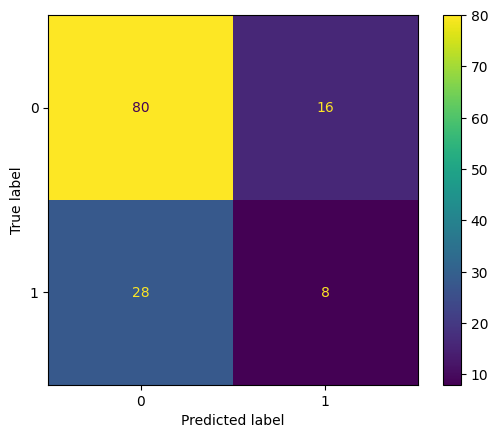

In [408]:
randomforest(df_oasis_24)

Mean accuracy of the model: 0.6071428571428571
Confusion matrix:



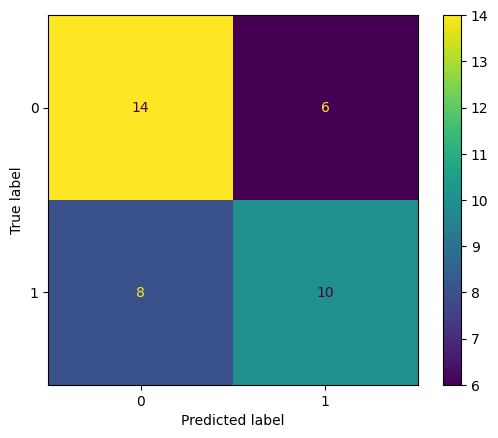

In [409]:
randomforest(df_oasis_24_2)

Mean accuracy of the model: 0.6903133903133905
Confusion matrix:



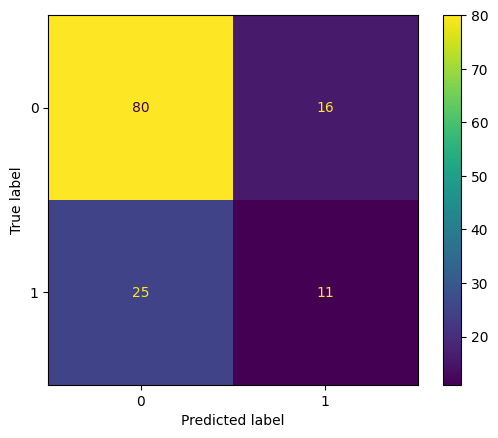

In [410]:
randomforest(df_oasis_48)

Mean accuracy of the model: 0.4666666666666666
Confusion matrix:



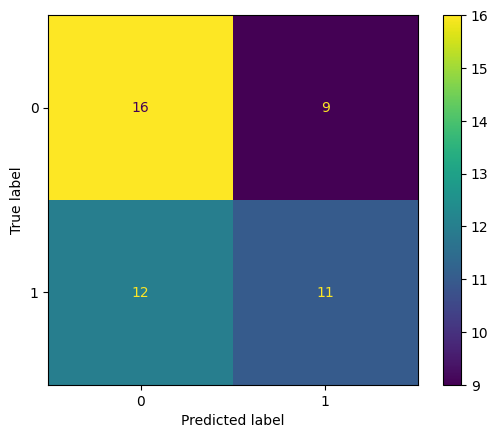

In [411]:
randomforest(df_oasis_48_2)

Note that, when we do not have NAN values in the oasis score the accuracy of the model is approtimately of 70%. When we have NAN values in the oasis score, as expected, we got less accuracy, approximately about 50%.

#Exercise 2:

1. Compute:
    - the number of different patients in the dataset
    - the number of different hospital admissions in the dataset
    - the number of different icu stays in the dataset
2. Show with an example that we can have a patient with more than one icustay.
3. Revise the number of ICU admissions registered by the two different systems: Metavision and Carevue.
4. Compute the number of NaN OASIS values for your different implementations.
5. Explain the difference between 'intime' from ICUSTAYS table and 'admittime' from ADMISSIONS table.


Your solution here

In [412]:
#Exercise 2
print('QUESTION 1\n')
print('The number of different patients in the dataset is:',df_admissions['subject_id'].nunique())
print('The number of different hospital admissions in the dataset is:', df_admissions['hadm_id'].nunique())
print('The number of different icu stays in the dataset is:', df_icustays['icustay_id'].nunique())

QUESTION 1

The number of different patients in the dataset is: 100
The number of different hospital admissions in the dataset is: 129
The number of different icu stays in the dataset is: 136


In [413]:
for subject in df_icustays['subject_id'].unique():
    if len(df_icustays[df_icustays['subject_id'] == subject]) >= 2:
        print(subject)

10059
10088
10094
10117
10119
10124
40124
40177
40304
40310
41795
41976
42135
42281
42346
43735
43746
43881
44083


In [414]:
print('QUESTION 2\n')
print('The patient 10059 has more than one icustay:\n')
df_icustays[df_icustays['subject_id']==10059]

QUESTION 2

The patient 10059 has more than one icustay:



,subject_id,hadm_id,icustay_id,intime,los
20,10059,142582,215460,2150-08-07 21:41:28,1.7806
21,10059,122098,248755,2150-08-22 17:33:50,7.1083


In [415]:
print('QUESTION 3\n')
df_icustays_ex2 = pd.read_csv('/content/drive/MyDrive/MASTER/SECOND SEMESTER/Health/First assignment/data/ICUSTAYS.csv')
print('The number of ICU admissions registered by the two different systems: Metavision and Carevue are the following:')
print(df_icustays_ex2['dbsource'].value_counts())

QUESTION 3

The number of ICU admissions registered by the two different systems: Metavision and Carevue are the following:
metavision    77
carevue       59
Name: dbsource, dtype: int64


In [416]:
#Question 4
print('Number of NaN in the 24 hours dataset', df_oasis_24['oasis'].isna().sum()) #without nans
print('Number of NaN in the 24 hours dataset', df_oasis_24_2['oasis'].isna().sum()) #allowing nans
print('Number of NaN in the 48 hours dataset', df_oasis_48['oasis'].isna().sum()) #withous nans
print('Number of NaN in the 48 hours dataset', df_oasis_48_2['oasis'].isna().sum())#allowing nans


Number of NaN in the 24 hours dataset 0
Number of NaN in the 24 hours dataset 94
Number of NaN in the 48 hours dataset 0
Number of NaN in the 48 hours dataset 84


QUESTION 5: Explain the difference between 'intime' from ICUSTAYS table and 'admittime' from ADMISSIONS table.


The main difference between 'intime' from the ICUSTAYS table and 'admittime' from the ADMISSIONS table is the following:

On one hand, admittime represents the time when the patient was initially admitted to the hospital. It marks the start of the patient's hospitalization journey, which could include time spent in various departments or wards before being transferred to the ICU.

In the other hand, intime  represents the time when the patient was specifically admitted to the intensive care unit. It marks the beginning of the patient's stay in the ICU, where they receive specialized care and closer monitoring due to critical illness or other medical conditions.

To summarize, admittime will always happen before intime because the patient has to be admitted to the hospital and then it may happen that they go to the ICU or not.

# Exercise 3:

Try to improve the prediction of the length of stay (LOS) of the ICU patients using all available variables (instead of the Oasis score) in the classification model learning a multidimensional decision boundary.

To carry out this exercise, we will significantly reduce our data. We will group all the observations of an icustay_id by averaging the values of the different columns, per icustay_id. In those values that have Nan's we will input the average of all the icustays_id. Then we will apply again random forest and see the results.

In [417]:
# Your solution here: We wont need this columns anymore
df_24_ex3 = df_24.drop(columns=['subject_id','hadm_id', 'admittime' , 'intime', 'itemid', 'time', 'urine_df', 'hours'])
df_48_ex3 = df_48.drop(columns=['subject_id','hadm_id', 'admittime' , 'intime', 'itemid', 'time', 'urine_df', 'hours'])

In [418]:
df_24_ex3 = create_df(df_24_ex3,np.unique(df_24_ex3['icustay_id']), nansum = True, ex1= False) #last parameter false because we're in exercise 3
df_48_ex3 = create_df(df_48_ex3,np.unique(df_48_ex3['icustay_id']), nansum = True, ex1= False)
df_24_ex3.head(2)

,icustay_id,los,admission_type,age,prelos,ventilated,temp_c,GCS_total,hrate,resp_rate,urine,MAP
0,201006,7.1173,emergency,69,54.837222,n,38.095241,7.00,84.285714,27.0,215.0,64.6
0,201204,1.9121,emergency,80,0.026667,n,35.592593,11.25,67.833333,18.5,260.0,NaN


In [419]:
def prepare_data(df):
  df_encoded = pd.get_dummies(df['admission_type'])
  df = pd.concat([df, df_encoded], axis=1)
  df['ventilated'] = df['ventilated'].replace({'y': 1, 'n': 0})
  df['los'] = np.where(df['los']<4, 0, 1)
  df = df.drop(columns = ['admission_type', 'icustay_id'])

  mean = df[['GCS_total', 'hrate', 'resp_rate', 'urine', 'MAP']].mean() #Inputting nans with the mean value
  df[['GCS_total', 'hrate', 'resp_rate', 'urine', 'MAP']] = df[['GCS_total', 'hrate', 'resp_rate', 'urine', 'MAP']].fillna(mean)

  return (df)

In [420]:
df_24_ex3= prepare_data(df_24_ex3)
df_48_ex3 = prepare_data(df_48_ex3)

In [421]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

def random_forest(df, test_size=0.2):

    X = df.drop('los', axis=1)
    y = df['los']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    confusion_matrices = []


    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]


        random_forest.fit(X_train_fold, y_train_fold)
        y_pred_fold = random_forest.predict(X_val_fold)
        fold_accuracy = accuracy_score(y_val_fold, y_pred_fold)
        fold_confusion_matrix = confusion_matrix(y_val_fold, y_pred_fold)

        cv_scores.append(fold_accuracy)
        confusion_matrices.append(fold_confusion_matrix)


    mean_accuracy = sum(cv_scores) / len(cv_scores)
    print("Mean Accuracy (Cross-Validation):", mean_accuracy)

    y_pred_test = random_forest.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print("Accuracy on Test Set:", test_accuracy)

    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix)
    disp.plot()

    return

Mean Accuracy (Cross-Validation): 0.780952380952381
Accuracy on Test Set: 0.8148148148148148


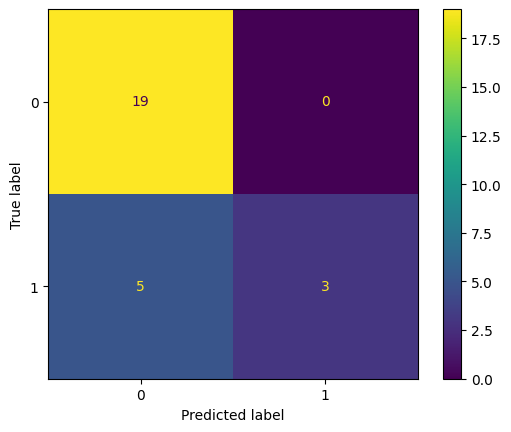

In [422]:
random_forest(df_24_ex3)

Mean Accuracy (Cross-Validation): 0.7523809523809524
Accuracy on Test Set: 0.7407407407407407


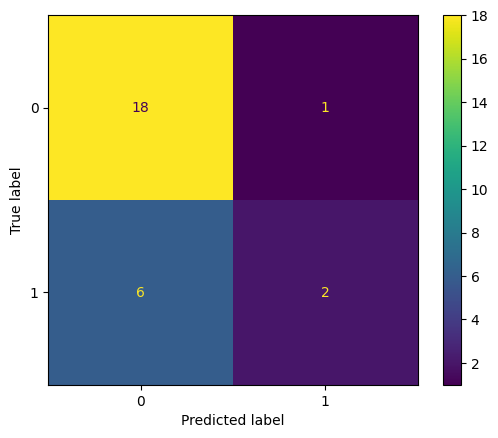

In [423]:
random_forest(df_48_ex3)

We can see how we have improved compared to the random forest carried out only with the oasis score (Exercise 1), although it is not a huge improvement: now we got 81% of accuracy with 24h and 74% with 48h. Note also the improvement in the TP,TN,FN and FP.